In [1]:
# Step 1: Import Libraries and Load Preprocessed Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print("Step 1: Libraries imported")

# Load the preprocessed data from Phase 1
final_data = pd.read_csv('data/preprocessed/dambulla_wholesale_cleaned.csv')
final_data['Date'] = pd.to_datetime(final_data['Date'])

print(f"Loaded data shape: {final_data.shape}")
print("Data types:")
print(final_data.dtypes)
print("\nFirst 5 rows:")
print(final_data.head())

Step 1: Libraries imported
Loaded data shape: (1782, 4)
Data types:
Date        datetime64[ns]
Location            object
Variety             object
Price              float64
dtype: object

First 5 rows:
        Date  Location       Variety  Price
0 2000-01-15  Dambulla  BITTER GOURD  15.55
1 2000-02-15  Dambulla  BITTER GOURD  13.95
2 2000-03-15  Dambulla  BITTER GOURD  15.10
3 2000-04-15  Dambulla  BITTER GOURD  18.12
4 2000-05-15  Dambulla  BITTER GOURD  26.00


In [2]:
# Step 2: Create Basic Time-Based Features
final_data['Year'] = final_data['Date'].dt.year
final_data['Month'] = final_data['Date'].dt.month
final_data['Quarter'] = final_data['Date'].dt.quarter
final_data['Day_of_year'] = final_data['Date'].dt.dayofyear

print("Step 2: Basic time-based features created")
print("New features added: Year, Month, Quarter, Day_of_year")
print(final_data[['Date', 'Year', 'Month', 'Quarter', 'Day_of_year']].head())

Step 2: Basic time-based features created
New features added: Year, Month, Quarter, Day_of_year
        Date  Year  Month  Quarter  Day_of_year
0 2000-01-15  2000      1        1           15
1 2000-02-15  2000      2        1           46
2 2000-03-15  2000      3        1           75
3 2000-04-15  2000      4        2          106
4 2000-05-15  2000      5        2          136


In [3]:
# Step 3: Create Seasonal Indicators
def get_season(month):
    if month in [12, 1, 2]:
        return 'Yala'  # Dry season
    elif month in [3, 4, 5]:
        return 'Maha'  # Main cultivation season
    elif month in [6, 7, 8]:
        return 'Intermediate1'
    else:
        return 'Intermediate2'

final_data['Season'] = final_data['Month'].apply(get_season)
final_data['Is_Yala'] = (final_data['Season'] == 'Yala').astype(int)
final_data['Is_Maha'] = (final_data['Season'] == 'Maha').astype(int)

print("Step 3: Seasonal indicators created")
print("Season distribution:")
print(final_data['Season'].value_counts())

Step 3: Seasonal indicators created
Season distribution:
Season
Yala             450
Intermediate1    450
Intermediate2    450
Maha             432
Name: count, dtype: int64


In [4]:
# Step 4: Create Lag Features
# Sort data by vegetable and date first
final_data = final_data.sort_values(['Variety', 'Date']).reset_index(drop=True)

# Create lag features for each vegetable
lag_features_data = []

for vegetable in final_data['Variety'].unique():
    veg_data = final_data[final_data['Variety'] == vegetable].copy()

    # Create lag features (previous months)
    veg_data['Price_lag1'] = veg_data['Price'].shift(1)  # 1 month lag
    veg_data['Price_lag2'] = veg_data['Price'].shift(2)  # 2 months lag
    veg_data['Price_lag3'] = veg_data['Price'].shift(3)  # 3 months lag
    veg_data['Price_lag6'] = veg_data['Price'].shift(6)  # 6 months lag
    veg_data['Price_lag12'] = veg_data['Price'].shift(12) # 12 months lag (seasonal)

    lag_features_data.append(veg_data)

# Combine all vegetables back
final_data_with_lags = pd.concat(lag_features_data, ignore_index=True)

print("Step 4: Lag features created")
print("Lag features added: Price_lag1, Price_lag2, Price_lag3, Price_lag6, Price_lag12")
print(f"Records with lag features: {len(final_data_with_lags)}")
print(final_data_with_lags[['Date', 'Variety', 'Price', 'Price_lag1', 'Price_lag2', 'Price_lag3']].head(10))

Step 4: Lag features created
Lag features added: Price_lag1, Price_lag2, Price_lag3, Price_lag6, Price_lag12
Records with lag features: 1782
        Date       Variety  Price  Price_lag1  Price_lag2  Price_lag3
0 2000-01-15  BITTER GOURD  15.55         NaN         NaN         NaN
1 2000-02-15  BITTER GOURD  13.95       15.55         NaN         NaN
2 2000-03-15  BITTER GOURD  15.10       13.95       15.55         NaN
3 2000-04-15  BITTER GOURD  18.12       15.10       13.95       15.55
4 2000-05-15  BITTER GOURD  26.00       18.12       15.10       13.95
5 2000-06-15  BITTER GOURD  30.17       26.00       18.12       15.10
6 2000-07-15  BITTER GOURD  23.38       30.17       26.00       18.12
7 2000-08-15  BITTER GOURD  25.19       23.38       30.17       26.00
8 2000-09-15  BITTER GOURD  26.31       25.19       23.38       30.17
9 2000-10-15  BITTER GOURD  30.94       26.31       25.19       23.38


In [5]:
# Step 5: Create Rolling Statistics
rolling_features_data = []

for vegetable in final_data_with_lags['Variety'].unique():
    veg_data = final_data_with_lags[final_data_with_lags['Variety'] == vegetable].copy()

    # Rolling averages
    veg_data['Rolling_Mean_3'] = veg_data['Price'].rolling(window=3, min_periods=1).mean()
    veg_data['Rolling_Mean_6'] = veg_data['Price'].rolling(window=6, min_periods=1).mean()
    veg_data['Rolling_Mean_12'] = veg_data['Price'].rolling(window=12, min_periods=1).mean()

    # Rolling standard deviation (volatility)
    veg_data['Rolling_Std_3'] = veg_data['Price'].rolling(window=3, min_periods=1).std()
    veg_data['Rolling_Std_6'] = veg_data['Price'].rolling(window=6, min_periods=1).std()

    # Price momentum (current price vs rolling average)
    veg_data['Price_vs_3MA'] = veg_data['Price'] - veg_data['Rolling_Mean_3']
    veg_data['Price_vs_6MA'] = veg_data['Price'] - veg_data['Rolling_Mean_6']

    # Price change percentages
    veg_data['Price_Change_1m'] = veg_data['Price'].pct_change(1)  # 1-month change
    veg_data['Price_Change_3m'] = veg_data['Price'].pct_change(3)  # 3-month change

    rolling_features_data.append(veg_data)

# Combine all vegetables back
final_data_with_rolling = pd.concat(rolling_features_data, ignore_index=True)

print("Step 5: Rolling statistics created")
print("Rolling features added: Rolling_Mean_3, Rolling_Mean_6, Rolling_Mean_12")
print("Volatility features: Rolling_Std_3, Rolling_Std_6")
print("Momentum features: Price_vs_3MA, Price_vs_6MA, Price_Change_1m, Price_Change_3m")

Step 5: Rolling statistics created
Rolling features added: Rolling_Mean_3, Rolling_Mean_6, Rolling_Mean_12
Volatility features: Rolling_Std_3, Rolling_Std_6
Momentum features: Price_vs_3MA, Price_vs_6MA, Price_Change_1m, Price_Change_3m


In [7]:
# Step 6: Create Year-over-Year Features
yoy_features_data = []

for vegetable in final_data_with_rolling['Variety'].unique():
    veg_data = final_data_with_rolling[final_data_with_rolling['Variety'] == vegetable].copy()

    # Year-over-Year price (same month, previous year)
    veg_data['YoY_Price'] = veg_data['Price'].shift(12)
    veg_data['YoY_Change'] = veg_data['Price'] - veg_data['YoY_Price']
    veg_data['YoY_Change_Pct'] = (veg_data['YoY_Change'] / veg_data['YoY_Price']) * 100

    yoy_features_data.append(veg_data)

# Combine all vegetables back
feature_engineered_data = pd.concat(yoy_features_data, ignore_index=True)

print("Step 6: Year-over-Year features created")
print("YoY features added: YoY_Price, YoY_Change, YoY_Change_Pct")

Step 6: Year-over-Year features created
YoY features added: YoY_Price, YoY_Change, YoY_Change_Pct


In [8]:
# Step 7: Handle Missing Values from Feature Engineering
# Count missing values before cleaning
missing_before = feature_engineered_data.isnull().sum().sum()

# Remove rows with too many missing values (especially from lag features)
feature_engineered_data_clean = feature_engineered_data.dropna()

missing_after = feature_engineered_data_clean.isnull().sum().sum()

print("Step 7: Missing values handled")
print(f"Missing values before cleaning: {missing_before}")
print(f"Missing values after cleaning: {missing_after}")
print(f"Records before cleaning: {len(feature_engineered_data)}")
print(f"Records after cleaning: {len(feature_engineered_data_clean)}")
print(f"Records removed: {len(feature_engineered_data) - len(feature_engineered_data_clean)}")

Step 7: Missing values handled
Missing values before cleaning: 396
Missing values after cleaning: 0
Records before cleaning: 1782
Records after cleaning: 1710
Records removed: 72


In [9]:
# Step 8: Feature Analysis and Summary
print("FEATURE ENGINEERING SUMMARY")
print("=" * 50)
print(f"Total features created: {len(feature_engineered_data_clean.columns)}")
print(f"Total records available for modeling: {len(feature_engineered_data_clean)}")

print("\nFeature categories:")
print("- Time features: Year, Month, Quarter, Day_of_year")
print("- Seasonal features: Season, Is_Yala, Is_Maha")
print("- Lag features: Price_lag1, Price_lag2, Price_lag3, Price_lag6, Price_lag12")
print("- Rolling features: Rolling_Mean_3, Rolling_Mean_6, Rolling_Mean_12")
print("- Volatility features: Rolling_Std_3, Rolling_Std_6")
print("- Momentum features: Price_vs_3MA, Price_vs_6MA, Price_Change_1m, Price_Change_3m")
print("- YoY features: YoY_Price, YoY_Change, YoY_Change_Pct")

print("\nData types:")
print(feature_engineered_data_clean.dtypes.value_counts())

FEATURE ENGINEERING SUMMARY
Total features created: 28
Total records available for modeling: 1710

Feature categories:
- Time features: Year, Month, Quarter, Day_of_year
- Seasonal features: Season, Is_Yala, Is_Maha
- Lag features: Price_lag1, Price_lag2, Price_lag3, Price_lag6, Price_lag12
- Rolling features: Rolling_Mean_3, Rolling_Mean_6, Rolling_Mean_12
- Volatility features: Rolling_Std_3, Rolling_Std_6
- Momentum features: Price_vs_3MA, Price_vs_6MA, Price_Change_1m, Price_Change_3m
- YoY features: YoY_Price, YoY_Change, YoY_Change_Pct

Data types:
float64           18
int32              4
object             3
int64              2
datetime64[ns]     1
Name: count, dtype: int64


In [10]:
# Step 9: Save Feature-Engineered Dataset
output_file = 'data/preprocessed/dambulla_wholesale_feature_engineered.csv'
feature_engineered_data_clean.to_csv(output_file, index=False)

print("Step 9: Feature-engineered dataset saved")
print(f"Output file: {output_file}")
print(f"Final dataset shape: {feature_engineered_data_clean.shape}")
print(f"Columns: {list(feature_engineered_data_clean.columns)}")

Step 9: Feature-engineered dataset saved
Output file: data/preprocessed/dambulla_wholesale_feature_engineered.csv
Final dataset shape: (1710, 28)
Columns: ['Date', 'Location', 'Variety', 'Price', 'Year', 'Month', 'Quarter', 'Day_of_year', 'Season', 'Is_Yala', 'Is_Maha', 'Price_lag1', 'Price_lag2', 'Price_lag3', 'Price_lag6', 'Price_lag12', 'Rolling_Mean_3', 'Rolling_Mean_6', 'Rolling_Mean_12', 'Rolling_Std_3', 'Rolling_Std_6', 'Price_vs_3MA', 'Price_vs_6MA', 'Price_Change_1m', 'Price_Change_3m', 'YoY_Price', 'YoY_Change', 'YoY_Change_Pct']


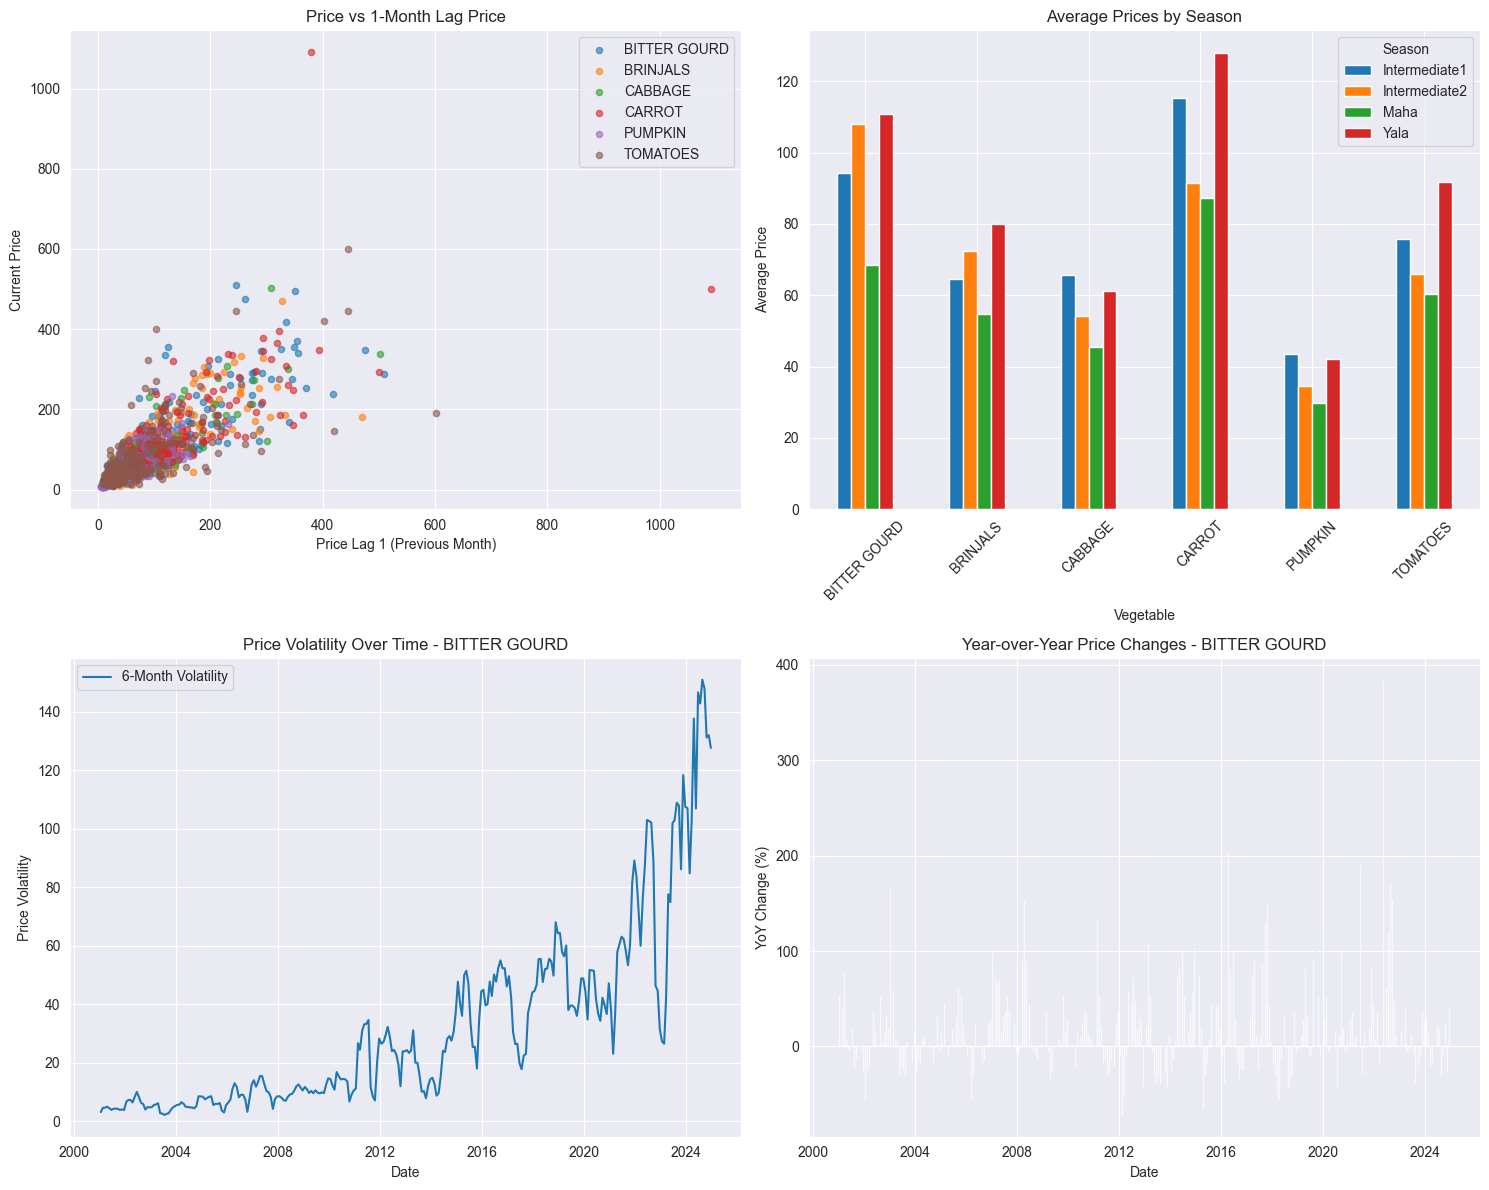

Step 10: Feature relationship visualizations created and saved


In [11]:
# Step 10: Visualize Feature Relationships
plt.figure(figsize=(15, 12))

# Plot 1: Price vs Lag1 for each vegetable
plt.subplot(2, 2, 1)
for veg in feature_engineered_data_clean['Variety'].unique():
    veg_data = feature_engineered_data_clean[feature_engineered_data_clean['Variety'] == veg]
    plt.scatter(veg_data['Price_lag1'], veg_data['Price'], alpha=0.6, label=veg, s=20)
plt.xlabel('Price Lag 1 (Previous Month)')
plt.ylabel('Current Price')
plt.title('Price vs 1-Month Lag Price')
plt.legend()

# Plot 2: Seasonal price patterns
plt.subplot(2, 2, 2)
seasonal_avg = feature_engineered_data_clean.groupby(['Variety', 'Season'])['Price'].mean().unstack()
seasonal_avg.plot(kind='bar', ax=plt.gca())
plt.xlabel('Vegetable')
plt.ylabel('Average Price')
plt.title('Average Prices by Season')
plt.xticks(rotation=45)

# Plot 3: Rolling volatility
plt.subplot(2, 2, 3)
sample_veg = feature_engineered_data_clean['Variety'].iloc[0]
sample_data = feature_engineered_data_clean[feature_engineered_data_clean['Variety'] == sample_veg]
plt.plot(sample_data['Date'], sample_data['Rolling_Std_6'], label='6-Month Volatility')
plt.xlabel('Date')
plt.ylabel('Price Volatility')
plt.title(f'Price Volatility Over Time - {sample_veg}')
plt.legend()

# Plot 4: Year-over-Year changes
plt.subplot(2, 2, 4)
yoy_sample = sample_data.dropna(subset=['YoY_Change_Pct'])
plt.bar(yoy_sample['Date'], yoy_sample['YoY_Change_Pct'], alpha=0.7)
plt.xlabel('Date')
plt.ylabel('YoY Change (%)')
plt.title(f'Year-over-Year Price Changes - {sample_veg}')

plt.tight_layout()
plt.savefig('data/preprocessed/feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("Step 10: Feature relationship visualizations created and saved")

In [ ]:
# Step 11: Final Phase 2 Completion Check
print("PHASE 2 COMPLETED SUCCESSFULLY!")
print("=" * 50)
print(f"Input file: data/preprocessed/dambulla_wholesale_cleaned.csv")
print(f"Output file: data/preprocessed/dambulla_wholesale_feature_engineered.csv")
print(f"Final dataset shape: {feature_engineered_data_clean.shape}")
print(f"Total features: {len(feature_engineered_data_clean.columns)}")
print(f"Total records: {len(feature_engineered_data_clean)}")
print(f"Vegetables: {len(feature_engineered_data_clean['Variety'].unique())}")
print("=" * 50)
print("Ready for Phase 3: Baseline Models!")